In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
import os

df = pd.read_csv('train.csv')

In [2]:
#將名目變數遺失值以「未提供」填補
df['性別'].replace('-','未提供', inplace=True)
df['星座'].replace('-','未提供', inplace=True)
df['聯絡地區'].replace('0','未提供', inplace=True)

df['年齡'].replace('-',0, inplace=True) #將年齡的缺失值以「0」填入
df['年齡'] = df['年齡'].astype(int) #將年齡型別轉換為 int
Bin = [18,24,30,36,42,48,54,60,66,72]
df['年齡組距'] = pd.cut(df.年齡, Bin) # 將年齡從18-72，以6為組距分組；18以下 & 72以上視為缺失值

df.年齡組距 = df.年齡組距.astype('object') # 將年齡組距的型別轉換為objcet
df.年齡組距.fillna("未提供", inplace=True) # 將18以下 & 72以上的缺失值，填入「未提供」

In [3]:
df['首購年份'] = pd.DatetimeIndex(df['訂單時間']).year # 新增首購年份欄位，從「訂單時間」中擷取年份

# 設定正則表達式
email = r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)"
phone = r"(^[0-9]+$)" 

# 將帳號轉換為帳號註冊方式
n = 0
for i in df.帳號:
    if re.match(email, i):
        df.帳號[n] = "email"
    if i[:3] == "FB@":
        df.帳號[n] = "FB"
    if re.match(phone, i):
        df.帳號[n] = "phone"

    # 利用迭代一併處理聯絡地區&供應商，將字串濃縮為三字
    df.聯絡地區[n] = df.聯絡地區[n][0:3]
    df.供應商[n] = df.供應商[n][0:3]
    n+=1

df['訂閱電子報'] = df['訂閱電子報'].map({'V':1, "0":0}) # 將是否訂閱電子報轉換為 1 & 0

df.set_index('購買會員代號', inplace=True) # 以會員代號作為Dataframe的index

In [4]:
# 選擇所需的變數
feature_selected = ['帳號', '性別', '年齡組距', '星座', '聯絡地區', '訂閱電子報', '首購季節', '首購服務', '交易金額','供應商' ]

X = df[feature_selected] # 依所選變數產生訓練集 X
X = pd.get_dummies(X) # 將訓練集的Object變數做 one-hot Coding
final_pred = X.loc[df[df['首購年份'] == 2020].index] #首購年份2020之會員為最終預測集

X = X.loc[df[df['首購年份'] != 2020].index] # 2020以前的資料，為訓練集
X_backup = X[:]  #保留原始訓練集

#建立回購與否預測驗證集
vail_X = X.sample(frac=0.2, replace=False) #從原始訓練及抽出20%作為驗證集
vail_y = df.loc[vail_X.index]['回購'] # 依驗證集的index，從原始資料集撈出對應的目標標籤
X.drop(vail_X.index, axis=0, inplace=True) #將被抽出的資料，從X訓練集中抽出
y = df.loc[X.index]['回購'] #依最後的X訓練集，匯出對應的目標標籤

In [5]:
# 因陽性標籤僅佔所有樣本約14%，極度不平衡。因此抽樣平衡標籤占比

from sklearn.utils import resample

X_upsampled, y_upsampled = resample(X[y == 1],
                                    y[y == 1],
                                    replace=True,
                                    n_samples=X[y == 0].shape[0],
                                    random_state=123)

X = pd.concat([X, X_upsampled])
y = pd.concat([y, y_upsampled])
X = X.sample(frac=1).reset_index(drop=True)
y = y.sample(frac=1).reset_index(drop=True)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

In [7]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

scaler = Normalizer()

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=50, 
                         learning_rate=0.1,
                         random_state=1)

pca = PCA(12)

lr = make_pipeline(scaler, pca, LogisticRegression())
svc = make_pipeline(scaler, pca, SVC())
knn = make_pipeline(scaler, pca, KNeighborsClassifier())
rf = make_pipeline(scaler, pca, RandomForestClassifier())
tree = make_pipeline(scaler, pca, tree)
ada = make_pipeline(scaler, pca, ada)

models = [lr, svc, knn, rf, tree, ada]
model_names = ['lr', 'svc', 'knn', 'rf', 'tree', 'ada']


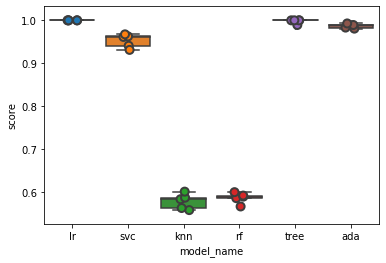

model_name
ada     0.986939
knn     0.577896
lr      1.000000
rf      0.586118
svc     0.952592
tree    0.997823
Name: score, dtype: float64

In [8]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# 用召回率作調參分數，繪製分類模型成效和型圖找出適合的分類器

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
scorer = make_scorer(recall_score, pos_label=1)
entries = []
n = 0
for model in models:
  model_name = model_names[n]
  accuracies = cross_val_score(model, X_train, y_train, scoring=scorer, cv=CV, n_jobs=-1)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
  n+=1
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'score'])

import seaborn as sns
sns.boxplot(x='model_name', y='score', data=cv_df)
sns.stripplot(x='model_name', y='score', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('model_name').score.mean()

# 除KNN與隨機森林以外，其他分類器有明顯過適的情況

In [9]:
# 使用巢狀交叉驗證調參
# 經測試後，僅KNN可以得出正常的分類結果，故選擇以KNN演算法作為預測模型


# param_grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}

param_grid={'n_neighbors':[8,9,10,11,12], 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
# param_grid={'n_neighbors':[9], 'weights':['uniform'], 'algorithm':['auto']}
# param_grid={"criterion":['gini', 'entropy'], "max_depth":[1,2,3,4]}

# param_grid={"n_estimators":[i for i in range(0,300,50)],
#  "criterion":["gini", 'entropy'],
#  'max_depth':[1,2,3,4],
#  'max_features':['auto', 'sqrt','log2']}

# param_grid={'C':np.logspace(-3,3,7), 'kernel':['rbf', 'sigmoid'], 'gamma':np.logspace(-3,3,7)}



grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring=scorer, cv=2, verbose=1, n_jobs=-1)


gs = make_pipeline(scaler,pca, grid_search)
gs.fit(X_train, y_train)
scores = cross_val_score(gs, X_train, y_train, 
                         scoring=scorer, cv=5)
print('CV precision: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))
grid_search.best_score_, grid_search.best_estimator_, grid_search.best_params_

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
Fitting 2 folds for each of 40 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.4s finished
Fitting 2 folds for each of 40 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.3s finished
Fitting 2 folds for each of 40 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elap

(0.6008708272859216,
 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                      weights='uniform'),
 {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'uniform'})

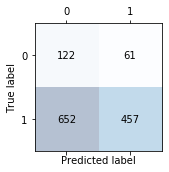

In [10]:
from sklearn.metrics import confusion_matrix
final_model = grid_search.best_estimator_
final_model.fit(X,y)

y_pred = final_model.predict(vail_X)
confmat = confusion_matrix(y_true=vail_y, y_pred=y_pred, labels=[1, 0])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [11]:
TP, FN, FP, TN = confmat[0,0], confmat[0,1], confmat[1,0], confmat[1,1]
acc = (TP+TN) / (TP+TN+FP+FN)
pre = TP / (TP+FP)
rec = TP / (FN+TP)
mark = input()
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

test_log = pd.read_csv('test_log.csv')
test_log.set_index('Id', inplace=True)
test_log.loc[len(test_log)+1] = [now, acc, pre, rec, grid_search.best_estimator_, mark]
test_log.to_csv('test_log.csv', encoding="utf_8_sig")

test_log # 將Test結果輸出備忘，記錄每次執行結果及其最佳參數

,Time,Acc,Pre,Rec,best_estimator_,other_mark
Id,,,,,,
1,2020-05-26 22:22:43,0.405573,0.129114,0.560440,"KNeighborsClassifier(algorithm='auto', leaf_si...",test
2,2020-05-28 10:09:26,0.438854,0.145288,0.606557,"KNeighborsClassifier(algorithm='auto', leaf_si...",123
3,2020-05-28 10:11:11,0.447368,0.136799,0.546448,"KNeighborsClassifier(algorithm='auto', leaf_si...",NaN
4,2020-05-28 10:14:48,0.424923,0.150754,0.641711,"KNeighborsClassifier(algorithm='auto', leaf_si...",pca=10
5,2020-05-28 10:18:25,0.407895,0.132754,0.618497,"KNeighborsClassifier(algorithm='ball_tree', le...",re_gs
...,...,...,...,...,...,...
70,2020-06-02 01:47:37,0.866099,NaN,0.000000,"LogisticRegression(C=0.001, class_weight=None,...",NaN
71,2020-06-02 01:48:24,0.856037,0.096774,0.018634,"KNeighborsClassifier(algorithm='auto', leaf_si...",NaN
72,2020-06-02 01:49:31,0.801084,0.133333,0.094675,"KNeighborsClassifier(algorithm='brute', leaf_s...",NaN


In [12]:
final_model = grid_search.best_estimator_
final_model.fit(X, y)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [13]:
vail_res = df.loc[vail_X.index]
vail_res['回購預測'] = final_model.predict(vail_X)
vail_res.to_csv('test_res.csv', encoding='utf_8_sig')


In [14]:
final_model = grid_search.best_estimator_
final_model.fit(pd.concat([X,vail_X]), pd.concat([y,vail_y]))

final_res = df.loc[final_pred.index]
final_res['回購預測'] = final_model.predict(final_pred)
final_res.to_csv('final.csv', encoding='utf_8_sig')